<strong><b><font size="5">Time Series Analysis and Forecasting in Python</font></b></strong>

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [3]:
df = pd.read_csv('fhv_base_aggregate_report_historical_1.csv')
df['pickup_start_date'] = pd.to_datetime(df['pickup_start_date'])
df = df[['pickup_start_date', 'total_dispatched_trips']]


In [4]:
df.columns = ['year','passengers']

In [44]:
df = df.groupby('year')['passengers'].sum().reset_index()
df = df.sort_values('year')
df

,year,passengers
0,2015-01-01,215142
1,2015-01-04,606408
2,2015-01-11,652688
3,2015-01-18,629682
4,2015-01-25,595317
...,...,...
188,2018-07-22,5055718
189,2018-07-29,4896653
190,2018-08-05,4950777
191,2018-08-12,4940561


In [45]:
df.describe()

,year,passengers
count,193,1.930000e+02
mean,2016-10-23 17:46:56.580310784,2.848305e+06
min,2015-01-01 00:00:00,2.151420e+05
25%,2015-11-29 00:00:00,1.861868e+06
50%,2016-10-23 00:00:00,2.809839e+06
75%,2017-09-24 00:00:00,3.834612e+06
max,2018-08-19 00:00:00,5.157863e+06
std,NaN,1.376716e+06


In [46]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01-01 00:00:00
Time period end: 2018-08-19 00:00:00


In [47]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [48]:
df.shape

(193, 2)

__Converting to datetime format:__

In [49]:
df['year'] = pd.to_datetime(df['year'])

__Setting index as the datetime column for easier manipulations:__

In [50]:
y = df.set_index('year')

In [51]:
y.index

DatetimeIndex(['2015-01-01', '2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25', '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22', '2015-03-01',
               ...
               '2018-06-17', '2018-06-24', '2018-07-01', '2018-07-08', '2018-07-15', '2018-07-22', '2018-07-29', '2018-08-05', '2018-08-12', '2018-08-19'], dtype='datetime64[ns]', name='year', length=193, freq=None)

In [52]:
y.isnull().sum()

passengers    0
dtype: int64

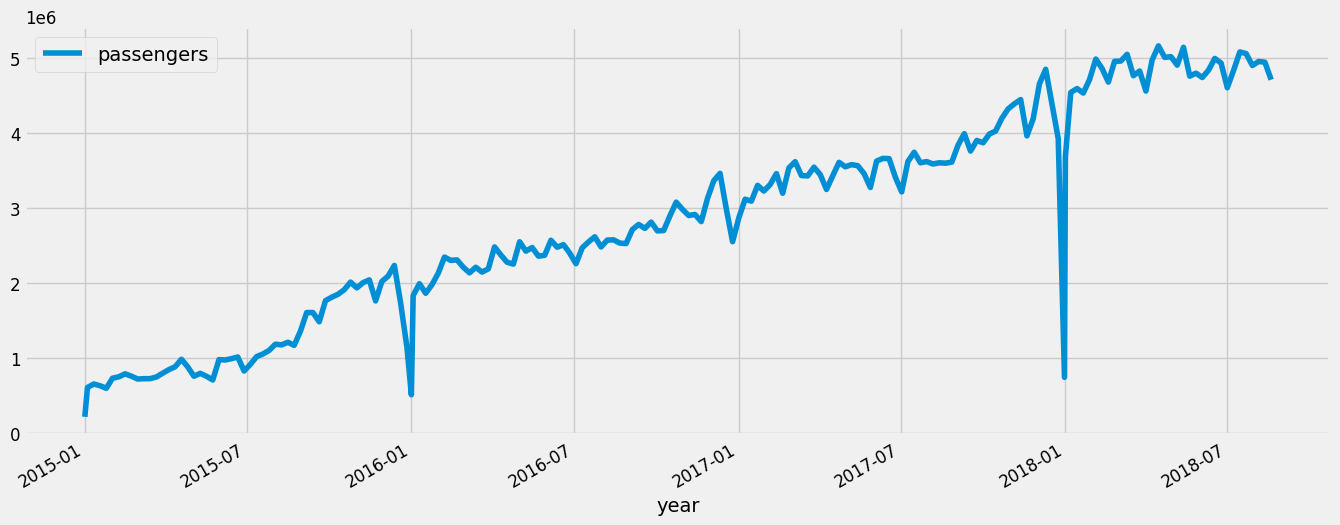

In [53]:
y.plot(figsize=(15, 6))
plt.show()

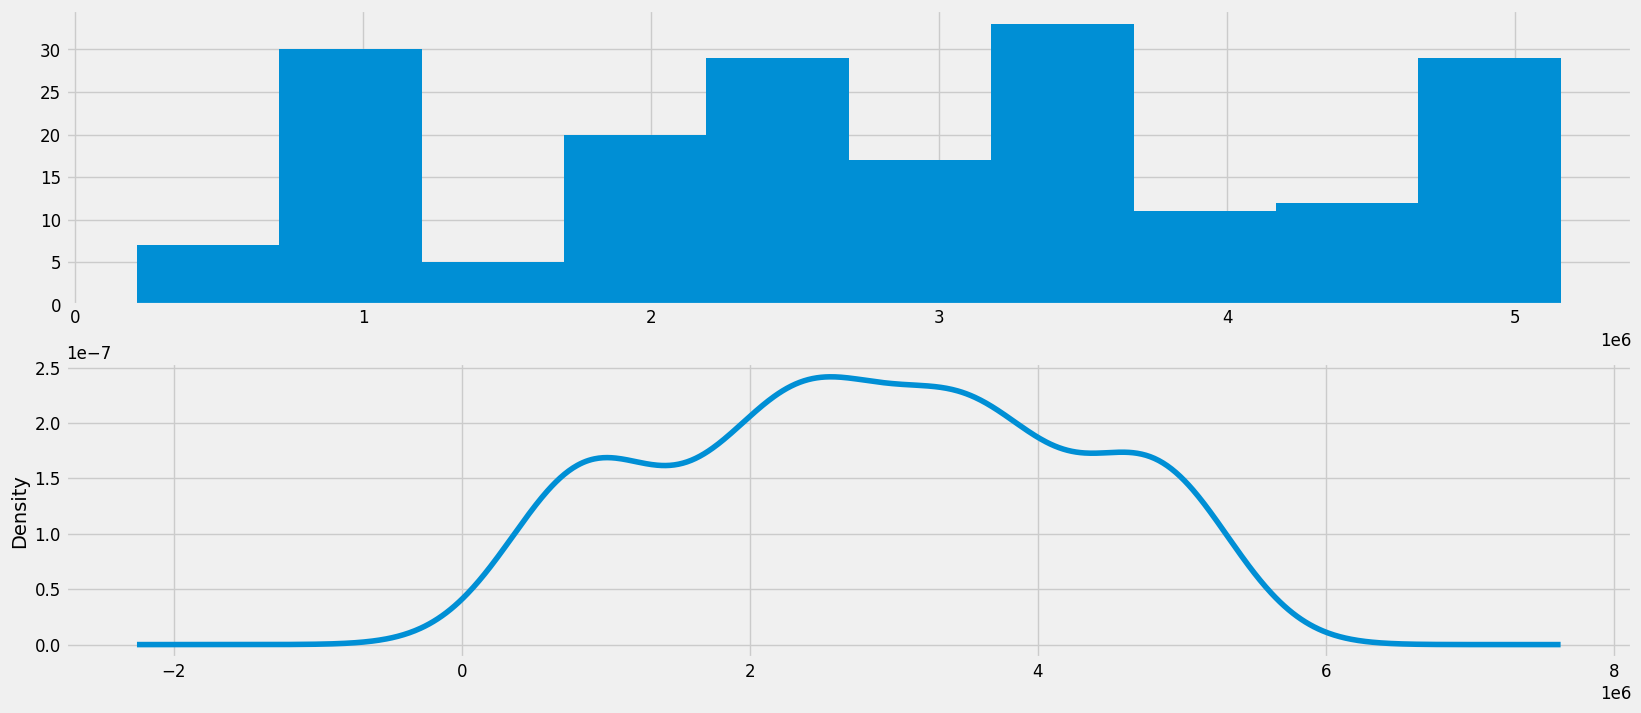

In [54]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

__Box and Whisker Plots:__
- Median values across years confirms an upwards trend
- Steady increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

<Axes: >

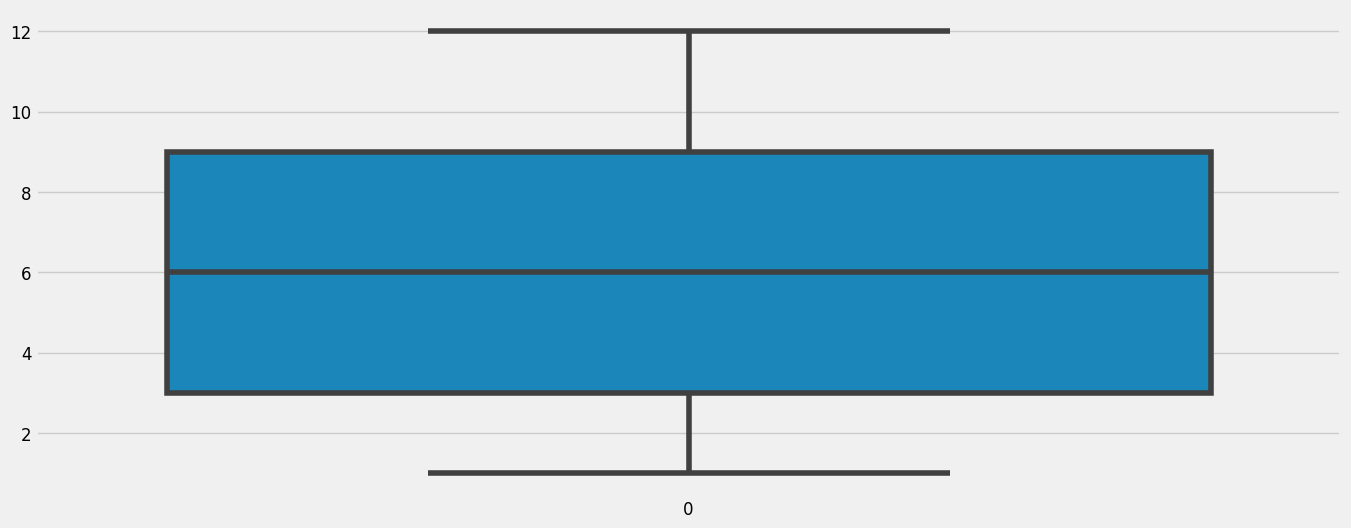

In [55]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.month)

__Decomposing using statsmodel:__
- We can use statsmodels to perform a decomposition of this time series. 
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. 
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

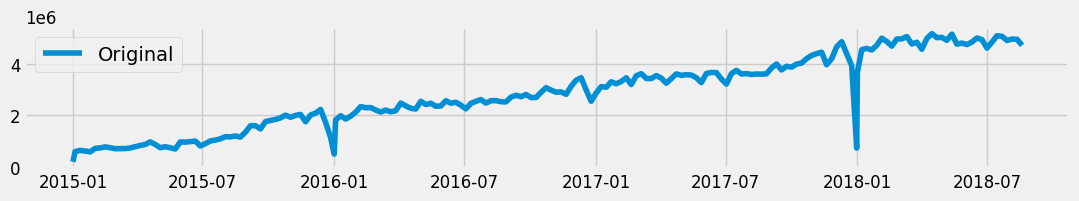

In [56]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(y['passengers'], label='Original')
plt.legend(loc='upper left')

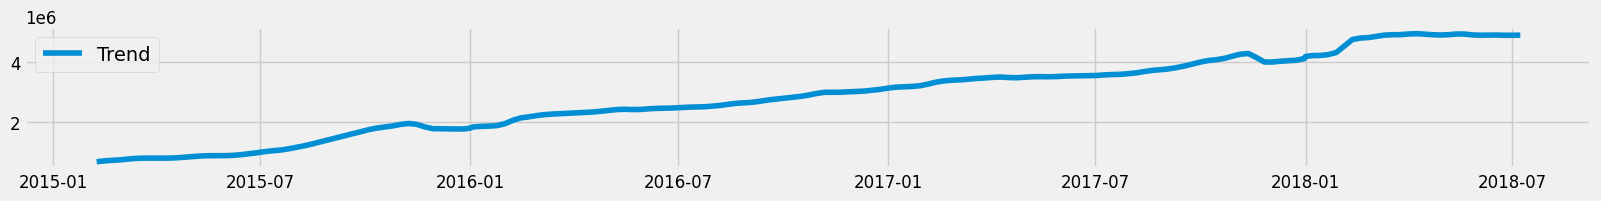

In [58]:
result = seasonal_decompose(y, model='multiplicative', period = 12)

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

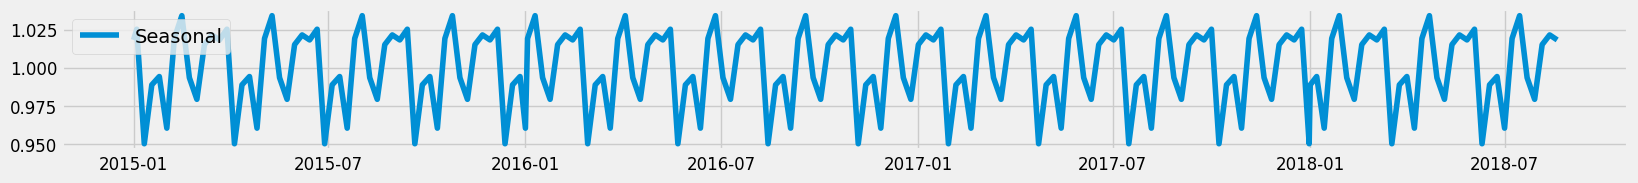

In [59]:
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

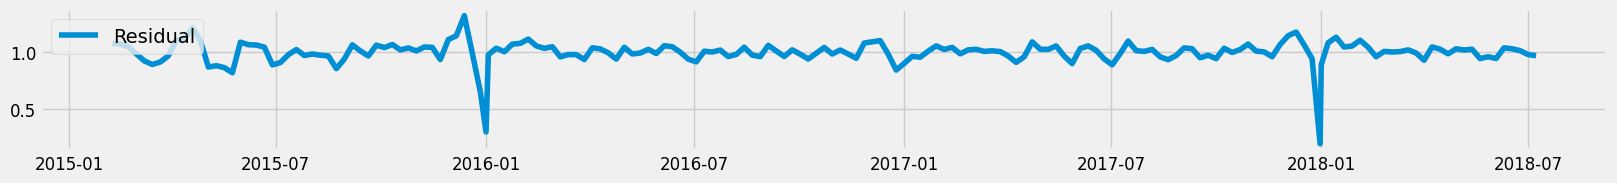

In [60]:
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

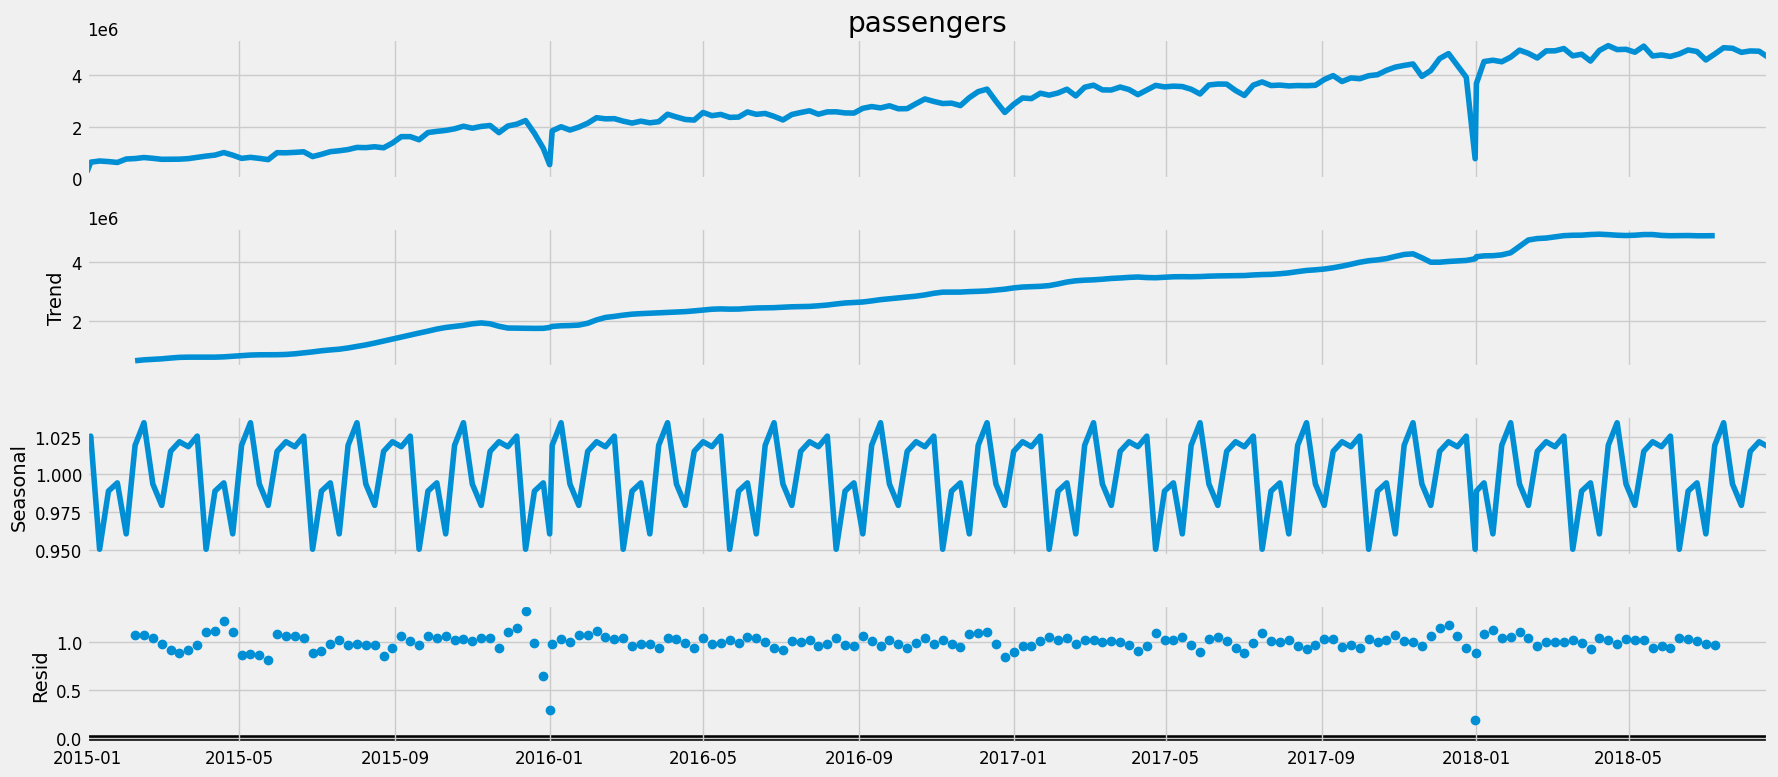

In [62]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y['passengers'], model='multiplicative',period=12)
fig = decomposition.plot()
plt.tight_layout()

plt.show()

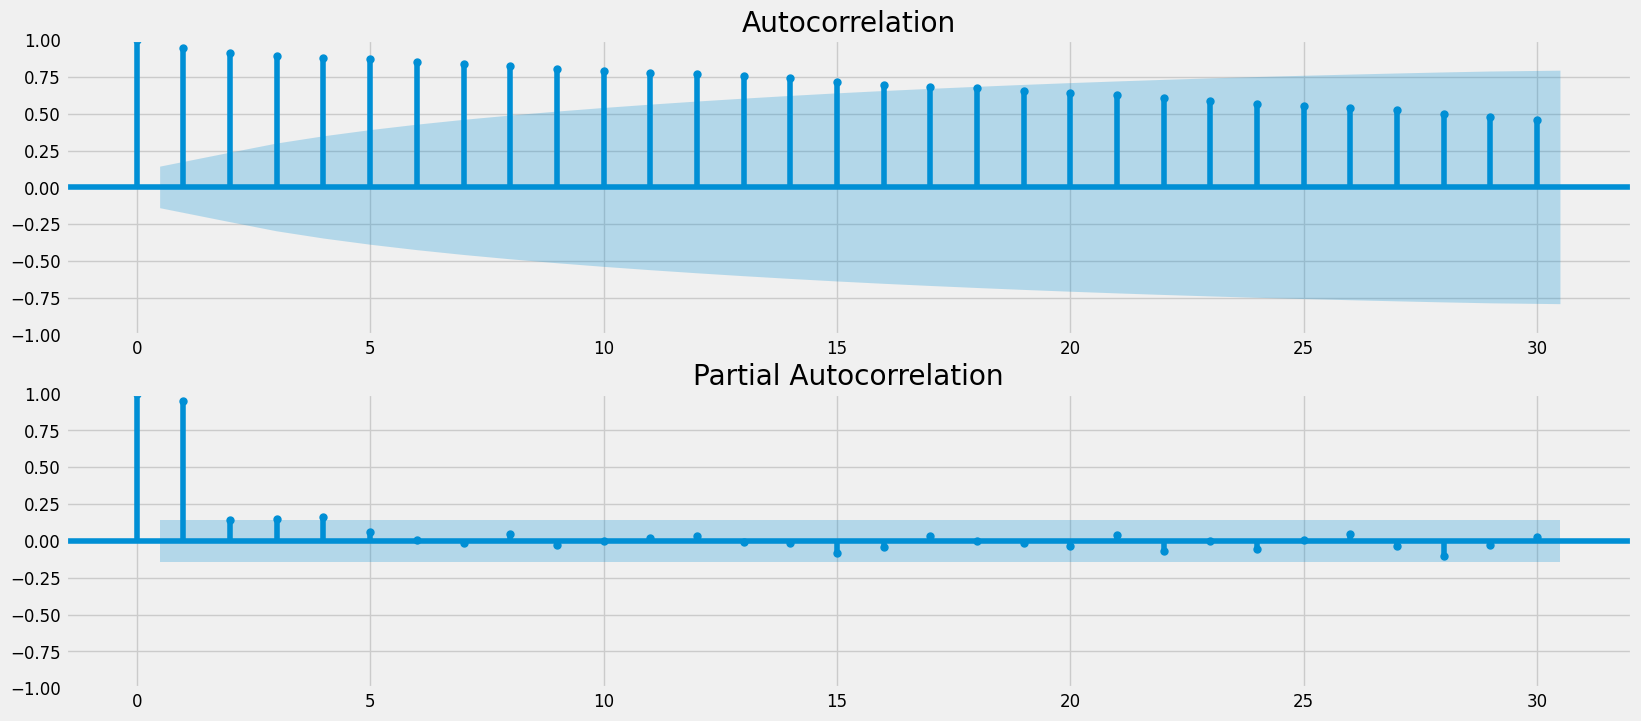

In [64]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

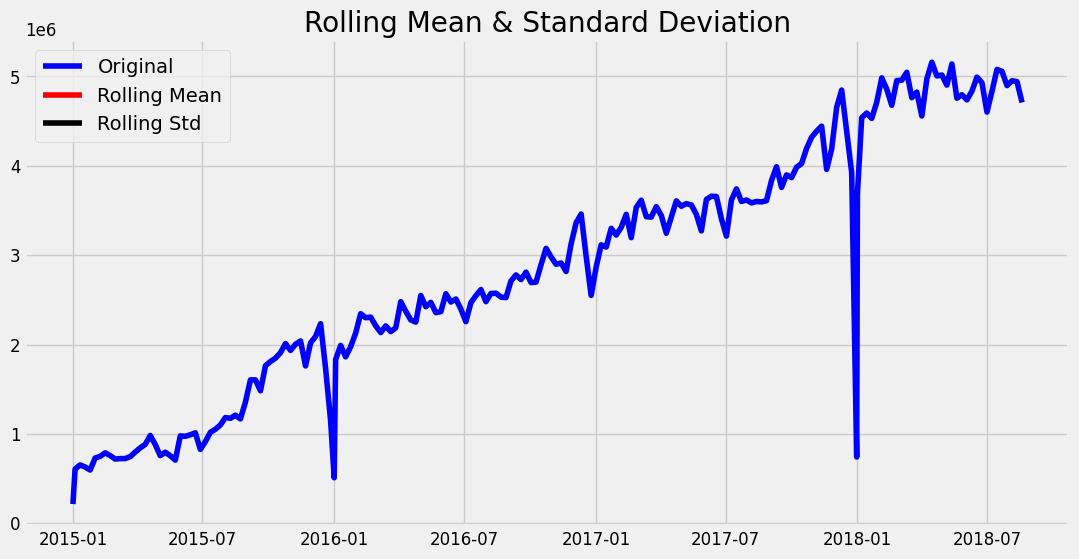

In [65]:
# Determing rolling statistics
rolmean = y.rolling(window=365).mean()
rolstd = y.rolling(window=365).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()



In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series):
    adf_result = adfuller(series)
    adf_statistic = adf_result[0]
    adf_p_value = adf_result[1]
    adf_critical_values = adf_result[4] 

    kpss_result = kpss(series)
    kpss_statistic = kpss_result[0]
    kpss_p_value = kpss_result[1]
    kpss_critical_values = kpss_result[3] 

    print("ADF Statistic:", adf_statistic)
    print("ADF p-value:", adf_p_value)
    print("KPSS Statistic:", kpss_statistic)
    print("KPSS p-value:", kpss_p_value)

    if adf_p_value > 0.05 and adf_statistic > adf_critical_values['1%'] and kpss_p_value < 0.05 and kpss_statistic > kpss_critical_values['1%']:
        print("Case 1: Both tests conclude that the series is not stationary -> series is not stationary")
    elif adf_p_value < 0.05 and adf_statistic < adf_critical_values['1%'] and kpss_p_value > 0.05 and kpss_statistic < kpss_critical_values['1%']:
        print("Case 2: Both tests conclude that the series is stationary -> series is stationary")
    elif adf_p_value > 0.05 and adf_statistic > adf_critical_values['1%'] and kpss_p_value > 0.05 and kpss_statistic < kpss_critical_values['1%']:
        print("Case 3: KPSS = stationary and ADF = not stationary -> trend stationary, remove the trend to make the series strictly stationary")
    elif adf_p_value < 0.05 and adf_statistic < adf_critical_values['1%'] and kpss_p_value < 0.05 and kpss_statistic > kpss_critical_values['1%']:
        print("Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make the series stationary")

test_stationarity(df['passengers'])

ADF Statistic: -0.8993967519222101
ADF p-value: 0.7881710110074317
KPSS Statistic: 1.9903558509932637
KPSS p-value: 0.01
Case 1: Both tests conclude that the series is not stationary -> series is not stationary


C:\Users\sassm\AppData\Local\Temp\ipykernel_35740\2390033672.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series)


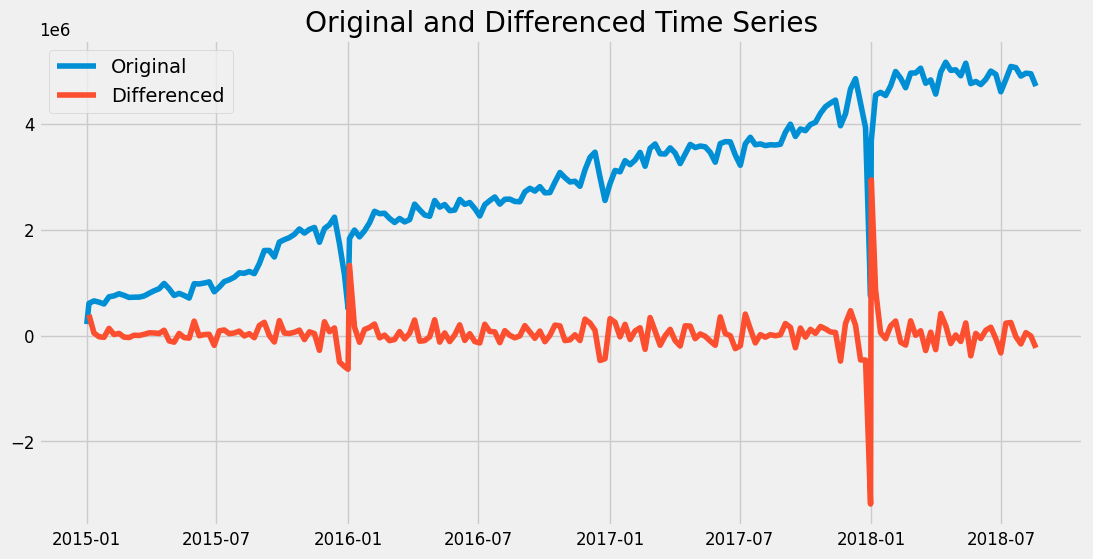

In [70]:
df_diff = df.diff().dropna()

# Plot the original and differenced time series
plt.figure(figsize=(12, 6))
plt.plot(df['passengers'], label='Original')
plt.plot(df_diff['passengers'], label='Differenced')
plt.legend()
plt.title('Original and Differenced Time Series')
plt.show()

In [71]:
test_stationarity(df_diff['passengers'])

ADF Statistic: -9.691251403397818
ADF p-value: 1.1349236382013433e-16
KPSS Statistic: 0.2341816604273479
KPSS p-value: 0.1
Case 2: Both tests conclude that the series is stationary -> series is stationary


C:\Users\sassm\AppData\Local\Temp\ipykernel_35740\2390033672.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series)


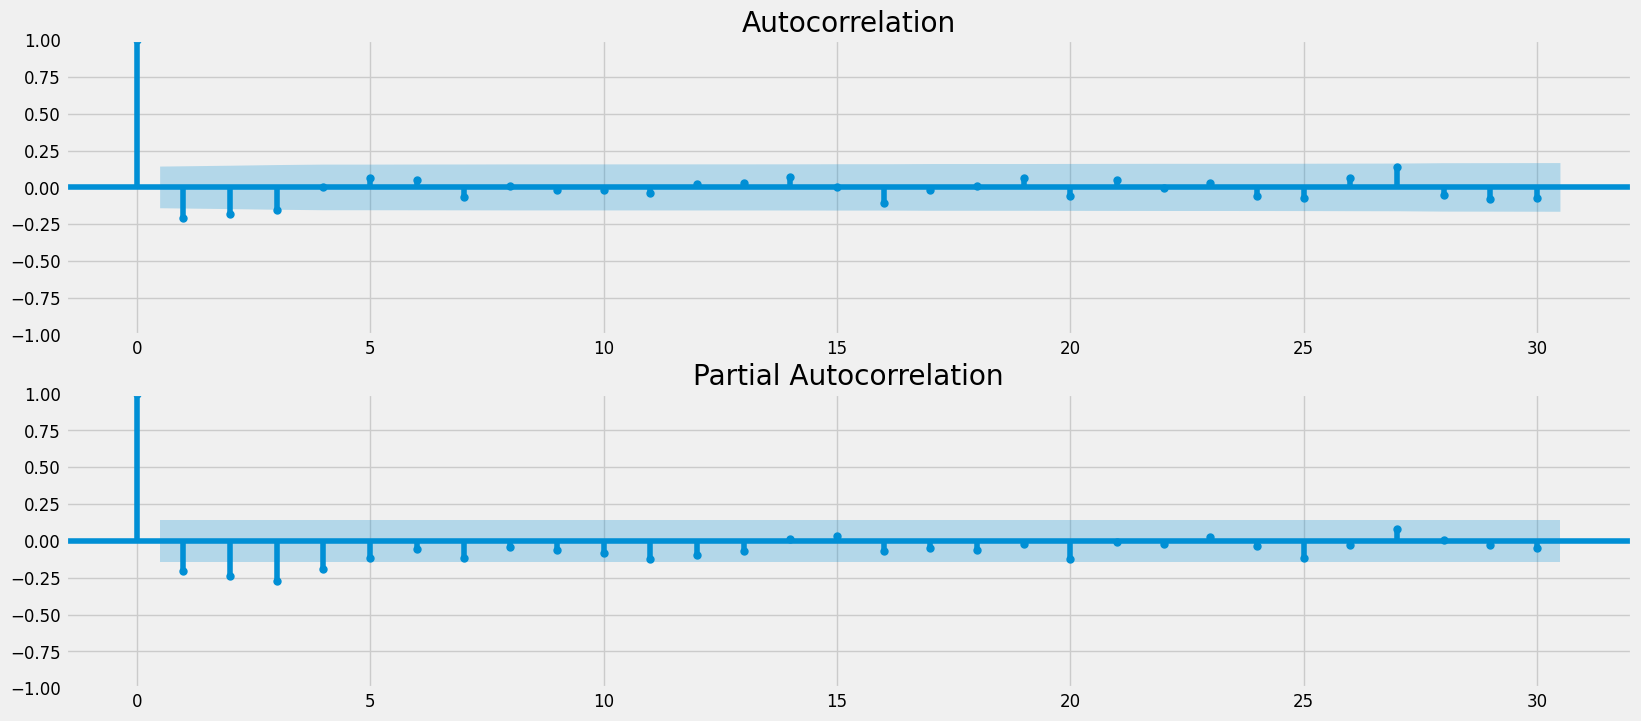

In [73]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(df_diff['passengers'], ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df_diff['passengers'], ax=pyplot.gca(), lags = 30)
pyplot.show()

In [74]:
train_size = int(len(df_diff) * 0.7)
train, test = df_diff[:train_size], df_diff[train_size:]

In [77]:
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(train, order=(4, 0, 2))
arma_fit = arma_model.fit()
print(arma_fit.summary())

c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  134
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1814.093
Date:                Sun, 19 Nov 2023   AIC                           3644.186
Time:                        23:15:23   BIC                           3667.369
Sample:                             0   HQIC                          3653.607
                                - 134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.631e+04   2614.659     10.063      0.000    2.12e+04    3.14e+04
ar.L1          0.9504      0.866      1.097      0.272      -0.747       2.648
ar.L2         -0.4079      0.622     -0.656      0.5

In [80]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

In [81]:
p_values = range(0, 20)  
d_values = range(0, 2)  
q_values = range(0, 10)  

best_aic = float("inf")
best_order = (0, 0, 0)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = ARIMA(train, order=order)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
            except:
                continue

best_model = ARIMA(train, order=best_order)
best_results = best_model.fit()

print(best_results.summary())

c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  135
Model:                 ARIMA(5, 1, 7)   Log Likelihood                   0.000
Date:                Sun, 19 Nov 2023   AIC                             26.000
Time:                        23:26:37   BIC                             63.672
Sample:                             0   HQIC                            41.309
                                - 135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6971         -0        inf      0.000      -1.697      -1.697
ar.L2         -0.6972   1.39e-08  -5.01e+07      0.000      -0.697      -0.697
ar.L3          0.6969   9.46e-09   7.37e+07      0.0

c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [84]:
arima_model = ARIMA(train, order=(5, 1, 7))
arima_fit = arima_model.fit()
arima_fit.summary()

c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  135
Model:                 ARIMA(5, 1, 7)   Log Likelihood                   0.000
Date:                Sun, 19 Nov 2023   AIC                             26.000
Time:                        23:31:36   BIC                             63.672
Sample:                             0   HQIC                            41.309
                                - 135                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6971         -0        inf      0.000      -1.697      -1.697
ar.L2         -0.6972   1.39e-08  -5.01e+07      0.000      -0.697      -0.697
ar.L3          0.6969   9.46e-09   7.37e+07      0.000       0.697       0.697
ar.L4          1.6970         -0       -inf      0.000       1.697       1.697
ar.L5          1.0000   6.79e-09   1.47e+08      0.000       1.000       1.000
ma.L1         -0.9885         -0        inf      0.000      -0.988      -0.988
ma.L2         -2.9919         -0        inf      0.000      -2.992      -2.992
ma.L3          2.9735         -0       -inf      0.000       2.974       2.974
ma.L4          2.9839         -0       -inf      0.000       2.984       2.984
ma.L5         -2.9815         -0        inf      0.000      -2.982      -2.982
ma.L6         -0.9920         -0        inf      0.000      -0.992      -0.992
ma.L7          0.9965         -0       -inf      0.000       0.997       0.997
sigma2      4.361e+10         -0       -inf      0.000    4.36e+10    4.36e+10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [87]:
arima_model = ARIMA(train, order=(15, 1, 1))
arima_fit = arima_model.fit()
arima_fit.summary()

c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  135
Model:                ARIMA(15, 1, 1)   Log Likelihood               -1819.416
Date:                Sun, 19 Nov 2023   AIC                           3672.831
Time:                        23:49:40   BIC                           3722.095
Sample:                             0   HQIC                          3692.850
                                - 135                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0510      0.096    -10.960      0.000      -1.239      -0.863
ar.L2         -0.4395      0.079     -5.550      0.000      -0.595      -0.284
ar.L3         -0.5409      0.133     -4.079      0.000      -0.801      -0.281
ar.L4         -0.2911      0.178     -1.631      0.103      -0.641       0.059
ar.L5         -0.0854      0.168     -0.507      0.612      -0.416       0.245
ar.L6          0.0308      0.204      0.151      0.880      -0.370       0.431
ar.L7          0.0304      0.185      0.165      0.869      -0.332       0.392
ar.L8         -0.0058      0.225     -0.026      0.979      -0.446       0.435
ar.L9          0.0355      0.237      0.150      0.881      -0.429       0.500
ar.L10         0.0040      0.223      0.018      0.986      -0.433       0.441
ar.L11         0.0332      0.236      0.141      0.888      -0.429       0.495
ar.L12         0.1187      0.220      0.541      0.589      -0.311       0.549
ar.L13         0.1359      0.192      0.706      0.480      -0.241       0.513
ar.L14         0.1052      0.200      0.525      0.599      -0.288       0.498
ar.L15         0.0753      0.146      0.517      0.605      -0.210       0.360
ma.L1          0.9715      0.070     13.790      0.000       0.833       1.110
sigma2      3.972e+10   1.54e-11   2.59e+21      0.000    3.97e+10    3.97e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               231.94
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                            -0.30
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.11e+36. Standard errors may be unstable.
"""

In [88]:
from datetime import datetime
new_date_str = input("Enter the new date in yyyy-mm-dd format: ")
new_date = datetime.strptime(new_date_str, "%Y-%m-%d")
forecast = arima_fit.get_forecast(steps=1)
predicted_value = forecast.predicted_mean.iloc[0]
print(f"Predicted value for {new_date_str}: {predicted_value}")

Predicted value for 2018-08-05: 3673633.7586857523


c:\Users\sassm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [89]:
df

,passengers
year,
2015-01-01,215142
2015-01-04,606408
2015-01-11,652688
2015-01-18,629682
2015-01-25,595317
...,...
2018-07-22,5055718
2018-07-29,4896653
2018-08-05,4950777
